## Import libraries

In [ ]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Accessing Google file system
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

MessageError: Error: credential propagation was unsuccessful

## Load data

In [ ]:
ATT_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/HotelReservationsPreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/HotelReservationsOutput.csv"

TRAIN_RATE=0.80

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

x_train: (29016, 16)
t_train: (29016, 1)
x_dev: (3627, 16)
t_dev: (3627, 1)


# PRIMERO PROBAMOS ALGORITMO DE OPTIMIZACIÓN SGD-Nesterov

## Initialize variables

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

## Set hyperparameters

In [ ]:
n_epochs = 600
lr = 0.001
batch_size = 512
n_neurons_per_hlayer = [1500, 1000,500,250,75,25]

## Build the deep neural model

In [ ]:
model = keras.Sequential(name="MyModelDL")

In [ ]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="relu"))
  #keras.layers.BatchNormalization()
  kernel_regularizer=keras.regularizers.l1(0.001)
  keras.layers.Dropout(rate=0.1)

model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid"))
kernel_regularizer=keras.regularizers.l1(0.001)
model.summary()

Model: "MyModelDL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1500)              25500     
                                                                 
 dense_9 (Dense)             (None, 1000)              1501000   
                                                                 
 dense_10 (Dense)            (None, 500)               500500    
                                                                 
 dense_11 (Dense)            (None, 250)               125250    
                                                                 
 dense_12 (Dense)            (None, 75)                18825     
                                                                 
 dense_13 (Dense)            (None, 25)                1900      
                                                                 
 dense_14 (Dense)            (None, 1)                 26

## Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              optimizer=tf.keras.optimizers.SGD(nesterov=True),
              metrics=["binary_accuracy"])

## Train the model

In [ ]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

202.46085239899992


## Get the results

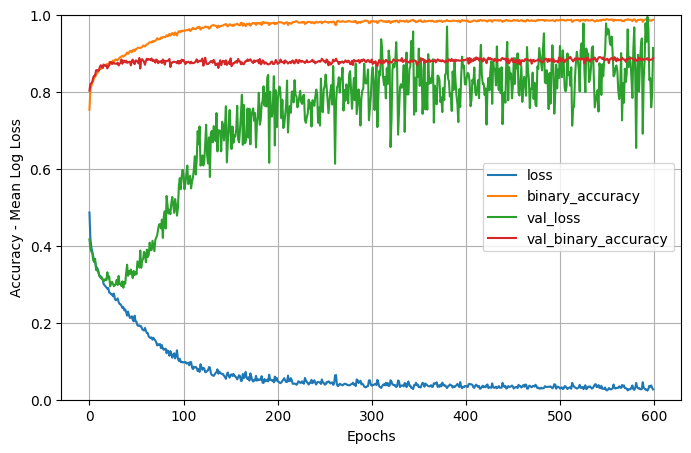

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.8758960366249084


In [ ]:
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the development test set:  0.8814446926116943


## Tenemos un buen nivel de error en training (1 - accuracy = 0.12) pero aún lejos del 5% de error humano planteado. Por otro lado, el sistema presenta muchas oscilaciones en validation_loss y validation_accuracy, por lo que se está observando algo de overfitting.

# Probamos ahora con el optimizador Adam

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["binary_accuracy"])

In [ ]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

KeyboardInterrupt: ignored

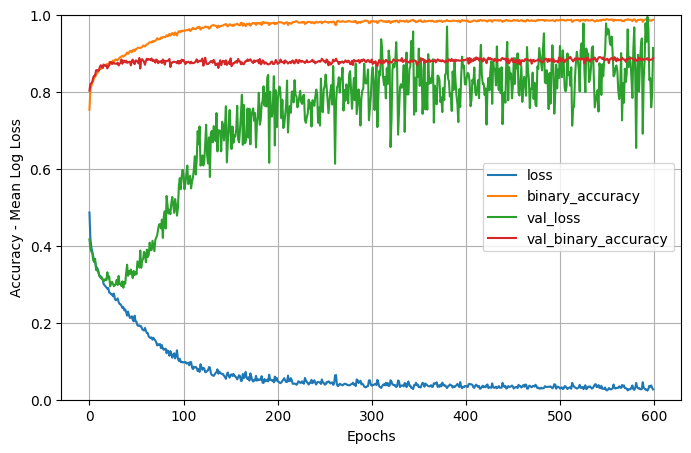

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.9870071411132812
Accuracy for the development test set:  0.887234628200531


## Observamos que con esta configuración de red de neuronas, el sistema presenta un overfitting severo. Para solucionarlo, primero reduciremos nº de neuronas, epochs y ampliaremos el mini-batch.

In [ ]:
n_epochs = 200
lr = 0.001
batch_size = 1024
n_neurons_per_hlayer = [500,250,75,25]

In [ ]:
model = keras.Sequential(name="MyModelDL")
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="relu"))
  #keras.layers.BatchNormalization()
  #kernel_regularizer=keras.regularizers.l1(0.001)
  #keras.layers.Dropout(rate=0.1)

model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid"))
#kernel_regularizer=keras.regularizers.l1(0.001)
model.summary()

Model: "MyModelDL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 500)               8500      
                                                                 
 dense_28 (Dense)            (None, 250)               125250    
                                                                 
 dense_29 (Dense)            (None, 75)                18825     
                                                                 
 dense_30 (Dense)            (None, 25)                1900      
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 154501 (603.52 KB)
Trainable params: 154501 (603.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["binary_accuracy"])

In [ ]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

KeyboardInterrupt: ignored

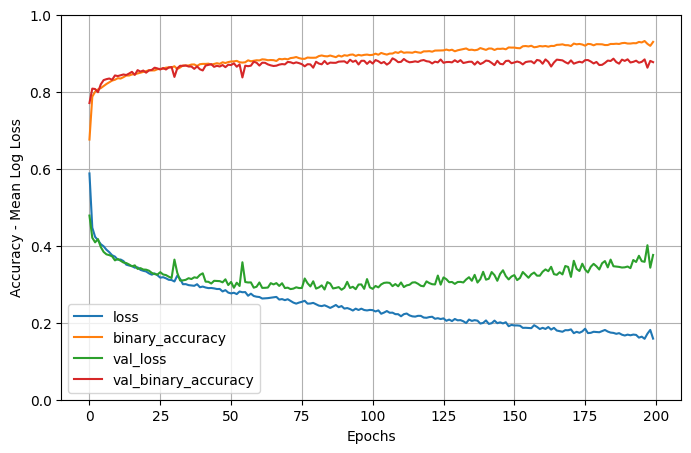

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.9294182658195496
Accuracy for the development test set:  0.8767576217651367


## Hemos conseguido reducir bastante el overfitting del sistema, teniendo además un bias de 2%. Por otro lado, presenta una varianza de ~5%. Vamos a reducir aún mas el nº de neuronas y modificaremos la función de activación de las capas densas de Relu a ELU.

In [ ]:
n_epochs = 200
lr = 0.001
batch_size = 1024
n_neurons_per_hlayer = [300,150,75,25]

In [ ]:
model = keras.Sequential(name="MyModelDL")
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="elu"))

model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid"))

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["binary_accuracy"])

In [ ]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

39.786071109999966


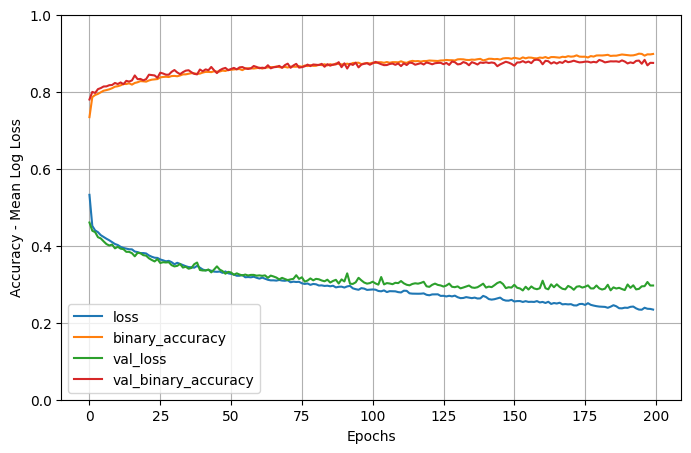

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.8980907201766968
Accuracy for the development test set:  0.8748276829719543


## Hemos conseguido reducir aún más el overfitting del sistema, aunque hemos aumentado el bias ~5%. Observando el validation_loss, se observa que a partir de las 150 epochs, el sistema empieza a tener peor eficacia, por lo que vamos a establecer ese nº como epochs. Por otro lado, vamos a incluir otra capa más de neuronas para intentar minimizar el bias y a incluir regularización L1 para reducir varianza.

In [ ]:
n_epochs = 100
lr = 0.001
batch_size = 1024
n_neurons_per_hlayer = [500, 300, 150, 75, 25]

In [ ]:
model = keras.Sequential(name="MyModelDL")
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="elu"))
  keras.layers.BatchNormalization()
  kernel_regularizer=keras.regularizers.l1(0.001)
  #keras.layers.Dropout(rate=0.1)

model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid"))
kernel_regularizer=keras.regularizers.l1(0.001)

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy ,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["binary_accuracy"])

In [ ]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

18.855507447000036


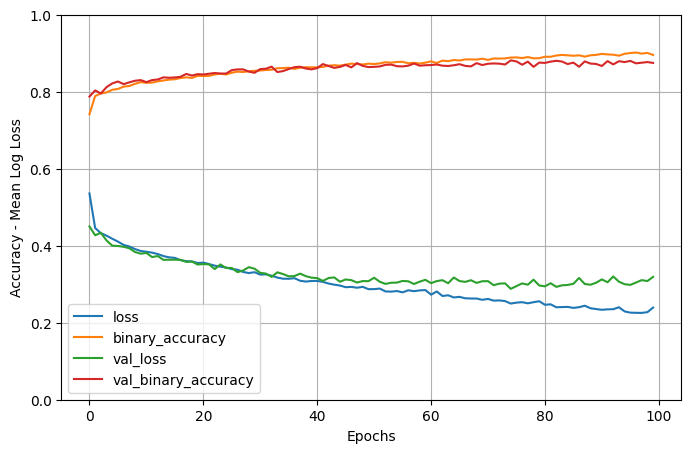

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
print ("Accuracy for the training set: ", results.binary_accuracy.values[-1:][0])
print ("Accuracy for the development test set: ", results.val_binary_accuracy.values[-1:][0])

Accuracy for the training set:  0.8955748677253723
Accuracy for the development test set:  0.8748276829719543
